In [283]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt
import csv
from scipy.stats import norm, binom
from scipy import stats
from scipy import linalg
import random
from decimal import Decimal
import pydtmc
from collections import Counter
import quantecon as qe
from mpl_toolkits.mplot3d import Axes3D
from random import randint
from tqdm.auto import tqdm

In [284]:
## Base parameters
"""
LC = 1 ## Lobby Cost
T = 10 ## Tax
mF = 10 ## Mean Fee of Getting Caught
nPPL = 11
fR = .25
R = nPPL * fR # enforcement resources

LobH = [2] ## Lobby History, arbitrary preset
CatH = [1] ## Catch history, arbitrary preset
"""

'\nLC = 1 ## Lobby Cost\nT = 10 ## Tax\nmF = 10 ## Mean Fee of Getting Caught\nnPPL = 11\nfR = .25\nR = nPPL * fR # enforcement resources\n\nLobH = [2] ## Lobby History, arbitrary preset\nCatH = [1] ## Catch history, arbitrary preset\n'

In [285]:
def pSS1(LobH, CatH, nPPL, fR): #Gets probability of lobbying successfully, subjective
    t = len(LobH) - 1
    pss = 1 - ((.8+CatH[t]) / (1+LobH[t]))
    #print(pss)
    return pss

In [286]:
def pCat(LobH, nPPL, fR):  #Gets objective probability of success 
    R = nPPL * fR
    t = len(LobH) - 1
    if LobH[t] <= R:
  #      print(.8)
        return .8
    else:
 #       print(.8 * (R / LobH[t]))
        return .8 * (R / LobH[t])

In [287]:
def it(LobH, CatH, LC, T, mF, nPPL, fR):
    t = len(LobH)
    ps = pSS1(nPPL = nPPL, fR = fR, LobH = LobH, CatH = CatH)
    LobH.append(0)
    CatH.append(0)
    for i in range(0,nPPL+1):
        if -T < (ps * -LC) + ((1-ps) * (-T - LC - (mF * np.random.normal(loc = 1, scale = 1.5)))):
            LobH[t] = LobH[t] + 1
            
    for i in range(0,LobH[t]+1):
        if random.random() < pCat(nPPL = nPPL, fR = fR, LobH = LobH):
            CatH[t] = CatH[t] + 1

In [288]:
def run(itr, LobH, CatH, LC, T, mF, nPPL, fR):
    for i in tqdm(range(0,itr)):
        it(LobH = LobH, CatH = CatH, LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR)

In [289]:
def set(LC, T, mF, nPPL, fR, itr):
    LobH = [randint(0,nPPL)] ## Lobby History, arbitrary preset
    CatH = [randint(0,LobH[0])] ## Catch history, arbitrary preset
    run(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr, LobH = LobH, CatH = CatH)
    return LobH, CatH

In [290]:

fR = .5
LC = 1
T = 15
mF = 5
nPPL = 20
LobH, CatH = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = 100000)


  3%|▎         | 3159/100000 [00:00<00:03, 31541.68it/s]

100%|██████████| 100000/100000 [00:03<00:00, 29327.44it/s]


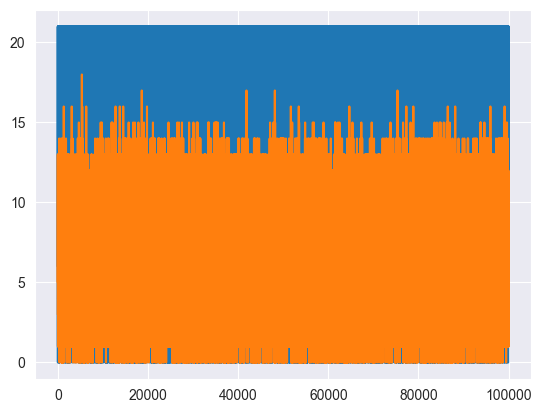

In [291]:
plt.plot(LobH)
plt.plot(CatH)

(array([11136., 15929., 15443., 11173.,  7377.,  5640.,  4750.,  4753.,
         5145., 18655.]),
 array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. ]),
 <BarContainer object of 10 artists>)

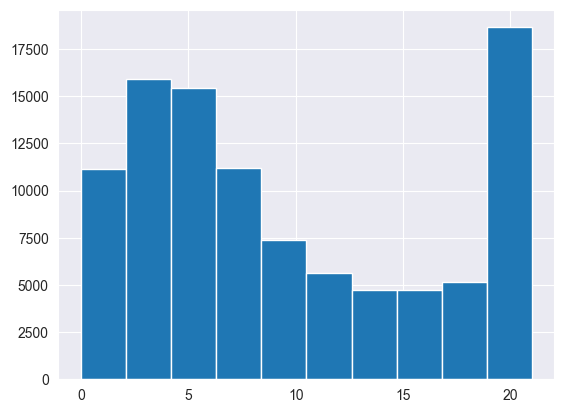

In [292]:
plt.hist(LobH, range = [0,nPPL+1])

In [293]:
def DynPDF(LC, T, mF, nPPL, fR, itr):
    LobH, CatH = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
    #nL = range(0,nPPL+1) # equals to list(set(words))
    #Lfreq = [x/(len(LobH)) for x in list(Counter(LobH).values())] # counts the elements' frequency
    count, bins_count = np.histogram(LobH, bins=nPPL+1)
    pdf = count / sum(count) 
    cdf = np.cumsum(pdf) 
    return pdf, bins_count

In [294]:
DPDF = DynPDF(fR = .5, LC = 1, T = 15, mF = 5, nPPL = 30, itr = 100000)[0]
TMPDF = [2.82981999e-05, 2.61439905e-04, 1.19061281e-03, 3.58043887e-03,
       8.04729296e-03, 1.45258078e-02, 2.21197522e-02, 2.94872534e-02,
       3.54276235e-02, 3.92642989e-02, 4.08987214e-02, 4.06535907e-02,
       3.90620647e-02, 3.66915530e-02, 3.40313779e-02, 3.14442008e-02,
       2.91655933e-02, 2.73294235e-02, 2.60001274e-02, 2.52016348e-02,
       2.49392845e-02, 2.52137970e-02, 2.60297267e-02, 2.74075191e-02,
       2.94117201e-02, 3.21981598e-02, 3.60752607e-02, 4.16384732e-02,
       5.03283008e-02, 6.73851386e-02, 1.54961513e-01]
stats.kstest(DPDF, TMPDF)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:04<00:00, 20351.33it/s]


KstestResult(statistic=0.2903225806451613, pvalue=0.14742010273046638, statistic_location=0.023349766502334977, statistic_sign=1)

In [300]:
def GraphDynPDF(LC, T, mF, nPPL, fR, itr):
    pdf, bins_count = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
    plt.plot(bins_count[1:], pdf, color="red", label="PDF")
    plt.ylim([0, 1])
    plt.legend()

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:03<00:00, 32422.49it/s]


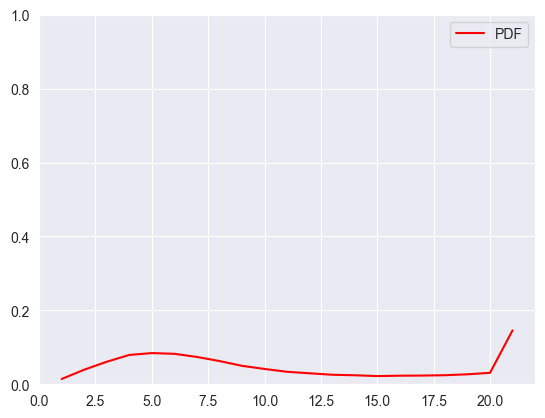

In [301]:
GraphDynPDF(fR = .5, LC = 1, T = 15, mF = 5, nPPL = 20, itr = 100000)

In [297]:
def DynItrR(LC, T, mF, nPPL, itr, bl):
    fR = 1 * bl
    RDis = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[0]
    for i in range(2,int(1/bl+1)):
        fR = i * bl
        tRDis = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[0]
        RDis = np.vstack([RDis, tRDis])
    return RDis

In [298]:
def GraphDynROut(LC, T, mF, nPPL, bl, itr):
    
    tnPPL = nPPL
    tLC = LC
    tT = T
    tmF = mF
    tbl = bl
    
    sns.set_style ("darkgrid")
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)

    x = range(0,nPPL+1)
    y = range(0,int(1/bl))

    data = DynItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, itr = itr, bl = bl)

    hf = plt.figure()
    ha = hf.add_subplot(projection='3d')

    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, data)

    ha.set_xlabel('nLobby')
    ha.set_ylabel('R')
    ha.set_zlabel('Probability')
    ha.set_title("3D Stationary Disrobutions based on R")

    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 78304.39it/s]


<Figure size 1000x1000 with 0 Axes>

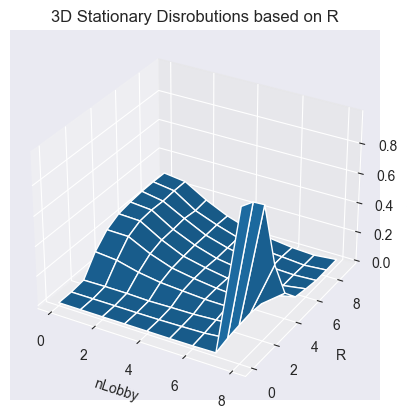

In [299]:
GraphDynROut(LC = 1, T = 15, mF = 5, nPPL = 8, bl = .1, itr = 10000)